In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import optim
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]

### 경락단가로 경락단가 예측

In [3]:
#df=df[['day_sentiment','경락단가_평균']]
df=df[['경락단가','경락단가_평균']]

df.tail()

# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 5
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

# # Input scale
# scaler_x = MinMaxScaler()
# scaler_x.fit(train_set.iloc[:, :-1])

# train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
# test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# # Output scale
# scaler_y = MinMaxScaler()
# scaler_y.fit(train_set.iloc[:, [-1]])

# train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
# test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 설정값
data_dim = 1
hidden_dim = 10 
global output_dim
output_dim= 4
learning_rate = 0.01
nb_epochs = 100
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length,output_dim):
    X_train = []
    y_train = []
    for i in range(0, len(time_series)-seq_length):
        X_train.append(time_series[i:i+seq_length, :-1])
        if len(time_series[i+seq_length:i+seq_length+output_dim, -1])!=output_dim:
            new_list=[]
            alist=time_series[i+seq_length:i+seq_length+output_dim, -1]
            print("alist----------------",alist)
            alist = np.concatenate((alist, np.array([alist[-1]] * (output_dim- len(time_series[i+seq_length:i+seq_length+output_dim, -1])))))
            y_train.append(alist)
            alist=[]
            new_list=[]
        else:
            y_train.append(time_series[i+seq_length:i+seq_length+output_dim, -1])
            #_y = time_series[i+seq_length:i+seq_length+output_dim , [-1]]
        # print(_x, "-->",_y)
    X_train, y_train = np.array(X_train), np.array(y_train)   
    return X_train, y_train

In [4]:
trainX, trainY = build_dataset(np.array(train_set), seq_length,output_dim)
testX, testY = build_dataset(np.array(test_set), seq_length,output_dim)

alist---------------- [3729.50909091 3839.60180995 3846.46728972]
alist---------------- [3839.60180995 3846.46728972]
alist---------------- [3846.46728972]
alist---------------- [4278.64948454 4322.08098592 4138.03719008]
alist---------------- [4322.08098592 4138.03719008]
alist---------------- [4138.03719008]


In [5]:
retrainX=trainX.reshape(-1,1)#(432, 5, 1)
retestX=testX.reshape(-1,1)#(188, 5, 1)

In [6]:
# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(retrainX)

retrainX = scaler_x.transform(retrainX)
retestX = scaler_x.transform(retestX)

In [7]:
trainX=retrainX.reshape(trainX.shape)
testX=retestX.reshape(testX.shape)

In [8]:
trainX.shape

(432, 5, 1)

In [9]:
retrainY=trainY.reshape(-1,1)#(432, 4)
retestY=testY.reshape(-1,1)#(188, 5, 1)

In [10]:
# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(retrainX)

retrainY = scaler_y.transform(retrainY)
retestY = scaler_y.transform(retestY)

In [11]:
trainY=retrainY.reshape(trainY.shape)
testY=retestY.reshape(testY.shape)

In [12]:
len(testX[1])

5

In [13]:
# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

In [14]:
# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

Epoch: 0000 train loss : 17713042.0000
Epoch: 0020 train loss : 17768420.0000

 Early Stopping


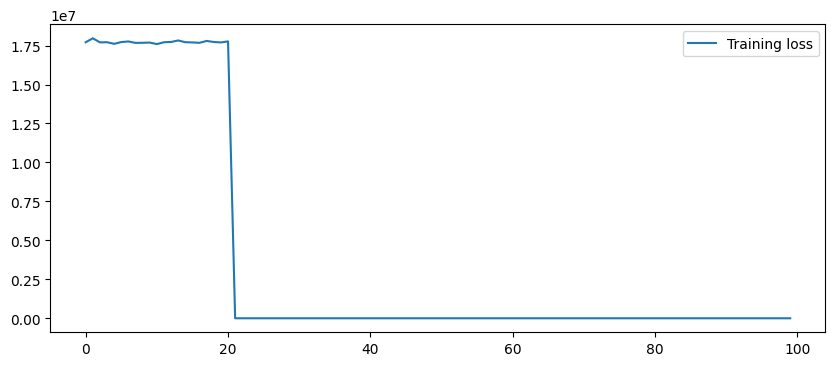

ValueError: only one element tensors can be converted to Python scalars

In [15]:
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        #print("x.shape",x.shape)
        return x

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train=x_train.to(device)
            y_train=y_train.to(device)
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# 모델 저장    
PATH = "./Timeseries_LSTM_data-02-stock_daily_.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0).to(device) ) 
        #predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    #(432, 4)
    #(188, 5, 1)
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1,1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor.reshape(-1,1))
    print("",pred_inverse)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

#MAE
from sklearn.metrics import mean_absolute_error

print("MAE",mean_absolute_error(testY_inverse,pred_inverse))

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(testY_inverse,pred_inverse))

#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(testY_inverse,pred_inverse)
print("MSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.

#MAPE
import numpy as np

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
print("MAPE",MAPE(testY_inverse, pred_inverse))

In [ ]:
np.array(pred)

In [ ]:
testY_tensor

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.legend()
plt.show()

### 도매가격+감성점수-> 도매가격

In [ ]:
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]

In [ ]:
#df=df[['day_sentiment','경락단가_평균']]
df=df[['day_sentiment','경락단가_평균']]


# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 5
batch = 100

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

# 설정값
data_dim = 1
hidden_dim = 10 
output_dim = 1
learning_rate = 0.01
nb_epochs = 100
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train=x_train.to(device)
            y_train=y_train.to(device)
            print("x_train",x_train)
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# 모델 저장    
PATH = "./Timeseries_LSTM_data-02-stock_daily_2.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0).to(device) )
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

In [ ]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

#MAE
from sklearn.metrics import mean_absolute_error

print("MAE",mean_absolute_error(testY_inverse,pred_inverse))

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(testY_inverse,pred_inverse))

#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(testY_inverse,pred_inverse)
print("MSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.

#MAPE
import numpy as np

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
print("MAPE",MAPE(testY_inverse, pred_inverse))

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.show()